In [1]:
!pip install pydev_jupyter_utils

ERROR: Could not find a version that satisfies the requirement pydev_jupyter_utils (from versions: none)
ERROR: No matching distribution found for pydev_jupyter_utils


In [2]:
import os
os.chdir("/home/jovyan/work/data/nasa_planet_gan/")

In [3]:
from IPython import display as ipydisplay
from PIL import Image
from importlib import reload
import pickle
import time
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as activations
import loadfunctions as lf
import tf_gan as tfg

In [4]:
input_width = 128
input_height = int(input_width*.75)
input_channels = 3
num_examples_to_generate = 16
noise_dim = 64
BATCH_SIZE = 128

In [5]:
reload(lf)
reload(tfg)

<module 'tf_gan' from '/home/jovyan/work/data/nasa_planet_gan/tf_gan.py'>

In [6]:
batch = tfg.create_batch(input_height,input_width, 20)
#print(batch.shape)
#grid = tfg.create_image_grid(batch,16)
#tfg.get_image(grid).show()
#for i in range(0,180,10):    
#    ex1 = batch[0]
#    ex1 = lf._rotate_and_crop(ex1,input_height,input_width,i)
#    try:
#        ex1=ex1.numpy()
#    except:
#        pass
#    tfg.get_image(ex1).show()
#

#ex2 = lf._rotate_and_crop(ex1.numpy().copy(),input_height,input_width,35)
#get_image(ex2.numpy()).show()

#get_image(batch[-1]).show()
#get_image(batch[-2]).show()

#tf.image.resize
#batch = create_batch(2,2)
#tfg.get_image(batch[-0]).show()
#tfg.get_image(batch[-1]).show()
#tfg.get_image(batch[-2]).show()

create_batch running init
creating resized np image array
creating resized np image array
done with resize, shape: (28, 96, 128, 3)
(0, 96, 128, 3)
28


2022-07-17 05:21:05.827171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-17 05:21:05.855841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-17 05:21:05.856262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-17 05:21:05.857214: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow wi

28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
shape of out: (28, 96, 128, 3)
number of augmented images for training: 1148
num unique: (1107, 96, 128, 3)


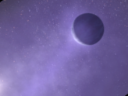

In [7]:
tf.keras.preprocessing.image.array_to_img(batch[
    random.randint(0,len(batch))]).show()


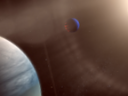

X_train: (1034, 96, 128, 3), X_test: (114, 96, 128, 3)


In [8]:
X_train= batch

np.random.shuffle(X_train)
tf.keras.preprocessing.image.array_to_img(X_train[0]).show()

test_num = int(len(X_train)*.1)
X = X_train[0:-test_num]
X_test = X_train[-test_num:]

print(f"X_train: {X.shape}, X_test: {X_test.shape}")

In [9]:
# function to provide the generator of the GAN
from tensorflow.keras.layers import BatchNormalization,Dense,Activation

def generator_model(output_width,output_height,output_channels,latent_dim):
    w8 = int(output_width/8)
    h8 = int(output_height/8)
    con_t_layers=[512,256,64,32,16,8,4,2]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(latent_dim,)))
    
    model.add(Dense(units=int(np.ceil(latent_dim/192)*192) ))
    model.add(BatchNormalization())
    model.add(Activation(activations.tanh))
    
    model.add(Dense(units=int(np.ceil(latent_dim/192)*192) ))
    model.add(BatchNormalization())
    model.add(Activation(activations.tanh))
    
    model.add(Dense(units=int(np.ceil(latent_dim/192)*192) ))
    model.add(BatchNormalization())
    model.add(Activation(activations.tanh))

    model.add(tf.keras.layers.Reshape(target_shape=(h8,w8,-1)))
    model.add(tf.keras.layers.Conv2DTranspose(filters=con_t_layers[0],kernel_size=(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Activation(activations.tanh))

    model.add(tf.keras.layers.Conv2DTranspose(filters=con_t_layers[1],kernel_size=(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Activation(activations.tanh))

    model.add(tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.Activation('tanh'))
    #model.add(tf.keras.layers.Add(1.0))

    return model

In [10]:
# function to provide the discriminator of the GAN
def discriminator_model(dropout =.1):
    drop_out_list = [dropout,
                     dropout,
                     dropout]
    filters_list = [2**7,2**8,2**9]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=filters_list[0],kernel_size=(5,5),strides=(2,2),padding='same',input_shape=(input_height,input_width,input_channels)))
    model.add(tf.keras.layers.Dropout(drop_out_list[0]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(filters=filters_list[1],kernel_size=(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.Dropout(drop_out_list[1]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(filters=filters_list[2],kernel_size=(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.Dropout(drop_out_list[2]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=1))
    model.add(tf.keras.layers.Activation('sigmoid'))
    return model

# function to provide the discriminator of the GAN
def discriminator_modelBroken():
    drop_out_list = [.5,.4,.33]
    filters_list = [8,16,32]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=filters_list[0],kernel_size=(5,5),strides=(2,2),padding='same',input_shape=(input_height,input_width,input_channels)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=8))
    model.add(tf.keras.layers.Dense(units=4))
    model.add(tf.keras.layers.Dense(units=2))
    model.add(tf.keras.layers.Activation('tanh'))

    model.add(tf.keras.layers.Dense(units=1))
    model.add(tf.keras.layers.Activation('sigmoid'))
    return model

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss,real_loss,fake_loss

In [13]:
def generator_loss(fake_output):
    # generator wants to fool the discriminator
    # so we must define a loss function for the generator

    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
# selective discriminator on 5,6,7,8,9
# no selective discriminator on 1,2,3,4,

# tanh on 6,7,8,9

scale = 4 # 1,2
scale = 20 #4,5,6
scale = 15 #7
scale = 10 #3,8,9
scale = 4 #X

disc_dropout_scale =  1 # 1,2,3,4,5,6,7,8,
disc_dropout_scale = .5 # 9
disc_dropout_scale = .1 # X

orig_gen = 4e-5
orig_dis = 5e-7

mod_gen = 4e-5+4e-5 #1,2,3,4,5,6,7,8,9
mod_dis = 5e-7+0    #1,2,3,4,5,6,7,8,9
mod_dis = .9e-7+0    #X

ratio = (4e-5/.5e-6)
ratio = ((orig_gen)/
         (orig_dis))

gen_lr = mod_gen*scale
disc_lr = mod_dis*scale

In [15]:
generator = generator_model(output_width=input_width,
                            output_height=input_height,
                            output_channels=input_channels,
                            latent_dim= 512)
print(generator.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 576)               295488    
                                                                 
 batch_normalization (BatchN  (None, 576)              2304      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 576)               0         
                                                                 
 dense_1 (Dense)             (None, 576)               332352    
                                                                 
 batch_normalization_1 (Batc  (None, 576)              2304      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 576)               0

In [16]:
discriminator = discriminator_model(dropout=disc_dropout_scale)
print(discriminator.summary())

#discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=.000002,beta_1=.5)
#discriminator.compile(loss='binary_crossentropy',optimizer=discriminator_optimizer,metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 64, 128)       9728      
                                                                 
 dropout (Dropout)           (None, 48, 64, 128)       0         
                                                                 
 batch_normalization_5 (Batc  (None, 48, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 48, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 32, 256)       819456    
                                                                 
 dropout_1 (Dropout)         (None, 24, 32, 256)       0         
                                                      

In [17]:

# a= b/c
# b= ac
# c=b/a
print(gen_lr,disc_lr,ratio,gen_lr/disc_lr)
generator_optimizer     = tf.keras.optimizers.Adam(gen_lr)

0.00032 3.6e-07 80.00000000000001 888.888888888889


In [18]:

discriminator_optimizer = tf.keras.optimizers.Adam(disc_lr)


In [19]:

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

seed = tf.random.normal([num_examples_to_generate, noise_dim])
#run_exp.noise = tf.random.normal([use_batch_size, exp.latent_dim])   



In [20]:


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False).numpy()
  print(predictions.shape,predictions.dtype)
  fig = plt.figure(figsize=(8,2),dpi=160)
  #fig = plt.figure()

  for i in range(predictions.shape[0]):
      plt.subplot(2, 8, i+1)
      plt.imshow((predictions[i, :, :, :] * 255).astype(np.uint8))
      plt.axis('off')  
  plt.show()

def save_images(image = None,noise= None,generator= None,epoch=None):
    if not image:
        #print("noise: ",noise)
        predictions = generator(noise, training=False).numpy()
        #print(predictions.shape,predictions.dtype)

        # create hstack the images
        all = [(x,y) for x in range(8) for y in range(2)]

        for i,t in enumerate(all):
            x,y = t
            display.np_img[
                y*input_height:(y+1)*input_height,
                x*input_width:(x+1)*input_width,
                :] = predictions[i,:,:,:]
        img = Image.fromarray(((display.np_img+1)* 128).astype(np.uint8))
    
    else:
        img = image
    
    img.save('predictions_at_epoch_{:04d}.png'.format(epoch+1))
    return img

def display(models:[],
            epoch,
            epoch_max,
            results_history,
            tot_batches,
            noise,
            plot_graphs=True,
            plot_images=True,
            ):
    if "np_img" not in dir():
        display.np_img= np.zeros(
            (
                input_height*2,
                input_width*8,
                input_channels
            )
        )
    
    start = time.time()
    
    # Produce images for the GIF as you go
    ipydisplay.clear_output(wait=False)
    if plot_images:
        save_images(noise=noise,generator =models[0],epoch=epoch).show()
        
    if plot_graphs:
        clrs = plt.cm.get_cmap("hsv", len(results_history))
        # make the plot wide
        plt.figure(figsize=(8,2),dpi=160)
        for i, key in enumerate(results_history):
            if ('epoch' not in key) & (key != "fooled")&('_lr' not in key)&('scale' not in key):
                clr = clrs(i)
                clr=[
                     max(clr[0]-(i/255),0),
                     max(clr[1]-(i/255),0),
                     max(clr[2]-(i/255),0)
                 ]
                plot_history_clipped = prepare_series_for_graph(results_history[key][-1000:], clip=True, smooth=False)
                plot_history_clipped_smoothed = prepare_series_for_graph(results_history[key][-1000:], clip=True, smooth=True)

                plt.plot(plot_history_clipped, linewidth=.5, alpha=.35, color=clr)
                # use a thinner line for the smoothed results_history
                plt.plot(plot_history_clipped_smoothed, label=key + ' smoothed', linewidth=1,alpha=.8, color=clr)

        plt.legend(loc= 'upper left')
        plt.show()

        #plot_history_clipped = prepare_series_for_graph(results_history["fooled"][-1000:], clip=True, smooth=False)
        #plot_history_clipped_smoothed = prepare_series_for_graph(results_history["fooled"][-1000:], clip=True, smooth=True)

        plt.figure(figsize=(8,2),dpi=160)
        plt.rcParams.update({'font.size': 5})
        #plt.plot(plot_history_clipped, linewidth=.5, alpha=.33)
        # use a thinner line for the smoothed results_history

        #plt.yscale('log')
        #plt.ylim(0,20)
        #plt.plot(results_history["fooled_per"], label="fooled_per", linewidth=1,alpha =.80)
        plt.plot(results_history["g_grad_scale_accum"][-1000:], label="g_grad_scale_accum" ,  linewidth=1,alpha =1)
        plt.plot(results_history["d_grad_scale_accum"][-1000:], label="d_grad_scale_accum" ,  linewidth=1,alpha =1)
        plt.plot(results_history["equilibrium_scale"][-1000:], label="equilibrium_scale" ,  linewidth=1,alpha =1)
        plt.plot(results_history["grad_scale_power"][-1000:], label="grad_scale_power" ,  linewidth=1,alpha =1)
        plt.legend(loc= 'upper left')
        plt.show()
        
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    # print the results average using f strings

    def mean(lst:[]):
        try:
            return sum(lst) / len(lst)
        except tf.errors.InvalidArgumentError as e:
            return tf.reduce_mean(tf.cast(lst,tf.float32))
        
    if "current_epoch" in results_history:
        results_history["last_epoch"] = results_history['current_epoch']

    results_history['current_epoch']={ k+"_mean":mean(v[-100:]) for k,v in results_history.items() if type(v)==list}

    print(f"gen_loss: {results_history['current_epoch']['gen_loss_mean']}")
    print(f"disc_loss: {results_history['current_epoch']['disc_loss_mean']}")
    print(f"fooled_per: {results_history['current_epoch']['fooled_per_mean']}")
    print(f"g_grad_scale_accum: {results_history['current_epoch']['g_grad_scale_accum_mean']}")
    print(f"d_grad_scale_accum: {results_history['current_epoch']['d_grad_scale_accum_mean']}")
    print(f"Epoch: {epoch + 1} / {epoch_max}")
    print(f"Batches: {tot_batches}")
    print(f"D Time: {time.time() - start} for images: {plot_images} and graphs: {plot_graphs}")
    





In [21]:
def maintain_history(_results_history,_results):
    if len(_results_history)==1:
        #_results_history = dict(_results)
        for key in _results:
            if key != 'epoch':
                _results_history[key] = []
    else:
        # append results to results_history
        for key in _results_history:
            if 'epoch' not in key:
                _results_history[key].append(_results[key])


    return _results_history

In [22]:

def train(generator,
          discriminator,
          dataset,
          epochs,
          start_epoch,
          results_history,
          d_grad_scale_accum,
          g_grad_scale_accum,
          grad_scale_power,
          example_noise,
          use_grad_scale):

    if start_epoch == -1 and os.path.exists('results_history.pkl'):
        try:
            print("Loading results_history from file")
            results_history = pickle.load(open('results_history.pkl', 'rb'))
            start_epoch = results_history['epoch']
        except:
            print("Could not load results_history.pkl")
            start_epoch = 0
    elif start_epoch ==-1:
        results_history={'epoch': 0,
                    'disc_loss': [],
                    'real_loss': [],
                    'fake_loss': [],
                    'gen_loss': [],
                    'fooled': [],
                    'g_grad_scale_accum': [],
                    'd_grad_scale_accum': [],
                    'fooled_per': [],
                    'equilibrium_scale': [],
                    'grad_scale_power': []}
    elif (start_epoch > 0):
        start_epoch= results_history['epoch']
    
    #d_grad_scale_accum = tf.Variable(1.0)
    
    print("Starting from epoch: ", start_epoch)

    
    for epoch in range(start_epoch,start_epoch+epochs):
        results_history["epoch"] = epoch

        start = time.time()
        tot_batches = 0
        # train on each batch and generates/updates results history

        mstart = time.time()
        ts_total_time=0.0
        print("Starting epoch {}".format(epoch+1))
        for image_batch in dataset:
            # accumulate the results of each train_step
            ts_start_time = time.time()
            if'current_epoch' in results_history:
                train._results = train_step(generator,discriminator,image_batch,
                                            selective_discriminator_training=False,
                                            hist=results_history['current_epoch'],
                                            d_grad_scale_accum= d_grad_scale_accum,
                                            g_grad_scale_accum=g_grad_scale_accum,
                                            grad_scale_power=grad_scale_power,
                                            use_grad_scale=use_grad_scale)
            else:
                train._results = train_step(generator,discriminator,image_batch,
                                            selective_discriminator_training=False,
                                            hist=None,
                                            d_grad_scale_accum= d_grad_scale_accum,
                                            g_grad_scale_accum=g_grad_scale_accum,
                                            grad_scale_power=grad_scale_power,
                                            use_grad_scale=use_grad_scale)

            ts_time = time.time() - ts_start_time
            ts_total_time += ts_time
            #train._results['gen_lr'] = [generator_optimizer.learning_rate.numpy()]*train._results['batch_size']
            #train._results['disc_lr'] = discriminator_optimizer.learning_rate.numpy()
            results_history=maintain_history(results_history,train._results)
            tot_batches += 1


        mend = time.time()
        print(f"Time for maintaining results: {mend - mstart-ts_total_time}")
        
        
        if epoch % 10 == 0:
            display.fig = plt.figure(figsize=(8,1.9),dpi=160)
            display([generator,discriminator],
                    epoch,
                    start_epoch+epochs,                    
                    results_history,
                    tot_batches,
                    noise=example_noise)
            # save results_history to disk as results_history.pkl
            with open('results_history.pkl', 'wb') as f:
                pickle.dump(results_history, f)
        save_images(noise=example_noise,generator =generator,epoch=epoch)
        print("Time for epoch: ", time.time() - start)

In [23]:
def prepare_series_for_graph(np_arr,smooth = True,clip =True):
    # print performance for this function
    s_time = time.time()
    out = np.array(np_arr)

    # smooth the results_history
    if smooth:
        out  = np.convolve(out, np.ones((10,))/10, mode='valid')
    # clip the results_history
    if clip:
        c=np.percentile(out, 95)
        out = out[out < c]
    e_time = time.time()
    #print(f"Time for smooth: {smooth} and clip: {clip} was {e_time - s_time}")

    return out.astype(np.float16)

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(generator,discriminator,
               images,               
               selective_discriminator_training,               
               hist,
               d_grad_scale_accum,
               g_grad_scale_accum,
               grad_scale_power,
               use_grad_scale:bool):
    noise = tf.random.normal((len(images),
                              generator.layers[0].input.shape[1]
                             ))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate noise to feed to the generator and get generated images.
        generated_images = generator(noise, training = generator.trainable)
        # call the discriminator with the real images and get its guesses
        real_output = discriminator(images, training = discriminator.trainable )
        # call the discriminator with the generated images and get the output
        fake_output = discriminator(generated_images, training = discriminator.trainable)
        gen_loss = generator_loss(fake_output)
        disc_loss,real_loss,fake_loss = discriminator_loss(real_output, fake_output)

    # track the number of fake images that fooled the discriminator where >.5
    fooled_per = tf.divide(tf.math.count_nonzero(fake_output > .5),BATCH_SIZE,"fooled_percent_calc")
    fooled = tf.math.count_nonzero(fake_output > .5)

    # Calculate the gradients for generator and discriminator.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)    
    report_d_grad_scale=1.0
    report_g_grad_scale=1.0
    equilibrium_scale=1.0
    #equilibrium_scale =tf.Variable(0,dtype=tf.float32)
    if use_grad_scale:
        #### Gen
        g_grad_scale = tf.subtract(            
            tf.cast(fooled_per ,dtype=tf.float32),
            tf.constant(.5, dtype=tf.float32)
        )
        g_grad_scale = g_grad_scale * -2
        # range is -1 to +1, +1 when 100% of samples in batch DO NOT fool the discriminator
        g_grad_scale = g_grad_scale * grad_scale_power
        
        
        
        #### Disc
        d_grad_scale = tf.subtract(            
            tf.cast(fooled_per ,dtype=tf.float32),
            tf.constant(.5, dtype=tf.float32)
        )
        d_grad_scale = d_grad_scale * 2
        # range is -1 to +1, +1 when 100% of samples in batch fool the discriminator
        d_grad_scale = d_grad_scale * grad_scale_power
        
        
        #equilibrium_scale=tf.cast((-((5*fooled_per)-2.5)**2+4)/6, dtype=tf.float32)*grad_scale_power
        equilibrium_scale=tf.cast((-((5.0*fooled_per)-2.0)**2.0+4.0)/4.0, dtype=tf.float32)*grad_scale_power
        #equilibrium_scale =(0.1(1/((fooled_per*4)−2)))**2
        
        d_grad_scale_accum.assign_add(d_grad_scale+equilibrium_scale)
        d_grad_scale_accum = tf.maximum(d_grad_scale_accum,-0.5)
        d_grad_scale_tot = tf.constant(1.0, dtype=tf.float32) + d_grad_scale_accum
        

        g_grad_scale_accum.assign_add(g_grad_scale+equilibrium_scale)        
        g_grad_scale_accum = tf.maximum(g_grad_scale_accum,-0.5)
        g_grad_scale_tot = tf.constant(1.0, dtype=tf.float32) + g_grad_scale_accum
        
        gradients_of_generator= [tf.math.scalar_mul(g_grad_scale_tot,grad) for grad in gradients_of_generator]
        gradients_of_discriminator= [tf.math.scalar_mul(d_grad_scale_tot,grad) for grad in gradients_of_discriminator]
                
        report_d_grad_scale=d_grad_scale_accum
        report_g_grad_scale=g_grad_scale_accum    
       
        
        
    # Apply gradients to the optimizer.
    generator.optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    #generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    if selective_discriminator_training:
        if gen_loss < 1:
            #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
            discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    else:
        discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # return a dictionary of disc_loss, real_loss, fake_loss, gen_loss,fooled
    disc_lr = tf.keras.backend.get_value(discriminator.optimizer.learning_rate)
    gen_lr = tf.keras.backend.get_value(generator.optimizer.learning_rate)
    return {'disc_loss': disc_loss,
            'real_loss': real_loss,
            'fake_loss': fake_loss,
            'gen_loss': gen_loss,
            'fooled': fooled,
            'g_grad_scale_accum': report_g_grad_scale,
            'd_grad_scale_accum': report_d_grad_scale,
            'fooled_per':fooled_per,
            'equilibrium_scale':equilibrium_scale,
            'grad_scale_power':grad_scale_power}



In [25]:

d_grad_scale_accum = tf.Variable(0.0)
g_grad_scale_accum = tf.Variable(0.0)

In [26]:
from dataclasses import dataclass
@dataclass
class experiment:
    name:str
    generator:None
    discriminator:None
    generator_src=None
    discriminator_src=None
    batch_size:int = 64
    train_shape:()=(0,0)
    example_noise = None
    g_lr:float=1e-6
    d_lr:float=1e-6
    start_gen_gsa:float=0.0
    start_disc_gsa:float=0.0
    grad_power:float=.01    
    epochs:int = 2000
    results_history=None
    use_grad_scale:bool=True
    latent_dim:int =100
    dropout:float=0.0
    
    

In [27]:
exp3 = experiment("exp3 - grad power higher .05",
                  g_lr=1e-6,
                  d_lr=1e-6,
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=0.05,
                  batch_size=64,
                  epochs=2000)
print(exp3.results_history,exp3.batch_size)
run_exp(exp3)

TypeError: __init__() missing 2 required positional arguments: 'generator' and 'discriminator'

In [ ]:
for i in exp3.results_history:
    print(i)
plt.plot(exp3.results_history["gen_lr"])
plt.plot(exp3.results_history["disc_lr"])
plt.show()
print(exp3.results_history["disc_lr"][-1])
print(exp3.results_history["gen_lr"][-1])

exp3a = experiment("exp3a - restart of prematurly ended exp3",
                  g_lr=1e-6,
                  d_lr=1e-6,
                  start_gen_gsa=-0.9288066,
                  start_disc_gsa=159.65173,
                  grad_power=0.05,
                  batch_size=64,                  
                  epochs=2000)
exp3a.results_history=exp3.results_history
print(exp3a)
run_exp(exp3a)

In [ ]:
overnight=[ experiment(f"-n2{x} exploring lr for model change in attempt to stop mode collapse {((x+0.5)**2.4/1_000_000):.3e}",
                  generator=None,
                  discriminator=None,
                  g_lr= ((x+0.5)**2.4/1_000_000),
                  d_lr= ((x+0.5)**2.4/1_000_000),
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.00001,
                  batch_size=[96],
                  epochs=500,
                  latent_dim = 3000
                      )
for x in range(1,8)]





for exp in overnight:
    print (exp.grad_power)
    
for exp in overnight:
    run_exp(exp)
    

In [ ]:
print(overnight[-3].generator.summary())

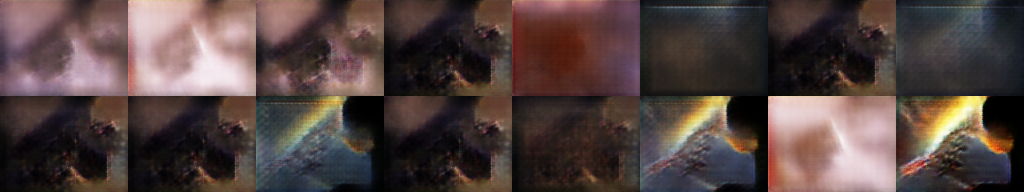

<Figure size 1280x304 with 0 Axes>

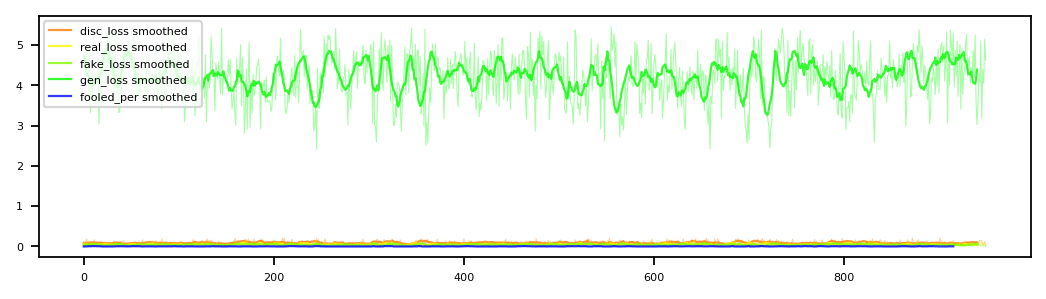

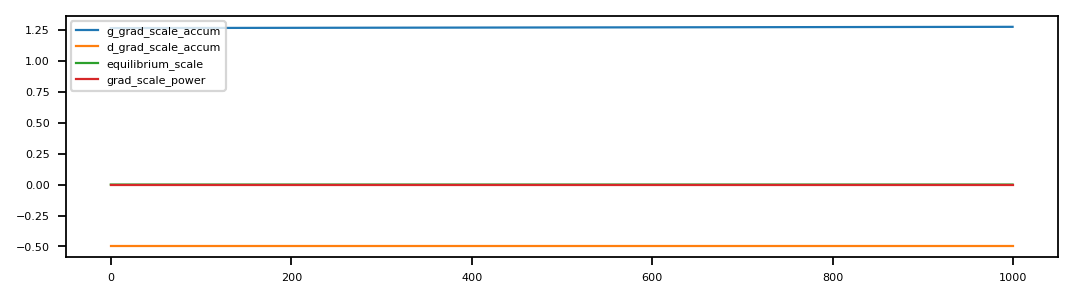

gen_loss: 4.499428749084473
disc_loss: 0.0843704342842102
fooled_per: 0.0034375
g_grad_scale_accum: 1.2732293605804443
d_grad_scale_accum: -0.5
Epoch: 2971 / 2971
Batches: 36
D Time: 1.9170289039611816 for images: True and graphs: True
Time for epoch:  16.177350282669067


In [31]:
exp_tmp = [experiment(f'new gen act (latent {ld}) (dropout {dropout}) (lr {lr}) batch (32)',
                  generator=None,
                  discriminator=None,
                  g_lr = 1.9e-5,
                  d_lr = lr,
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.00001,
                  batch_size=[32],
                  epochs=3300,
                  latent_dim = ld,
                  dropout=dropout
                     )
for ld,dropout,lr in [
    (650,.33,2.00e-6),

]]
for exp in exp_tmp:
    run_exp(exp)


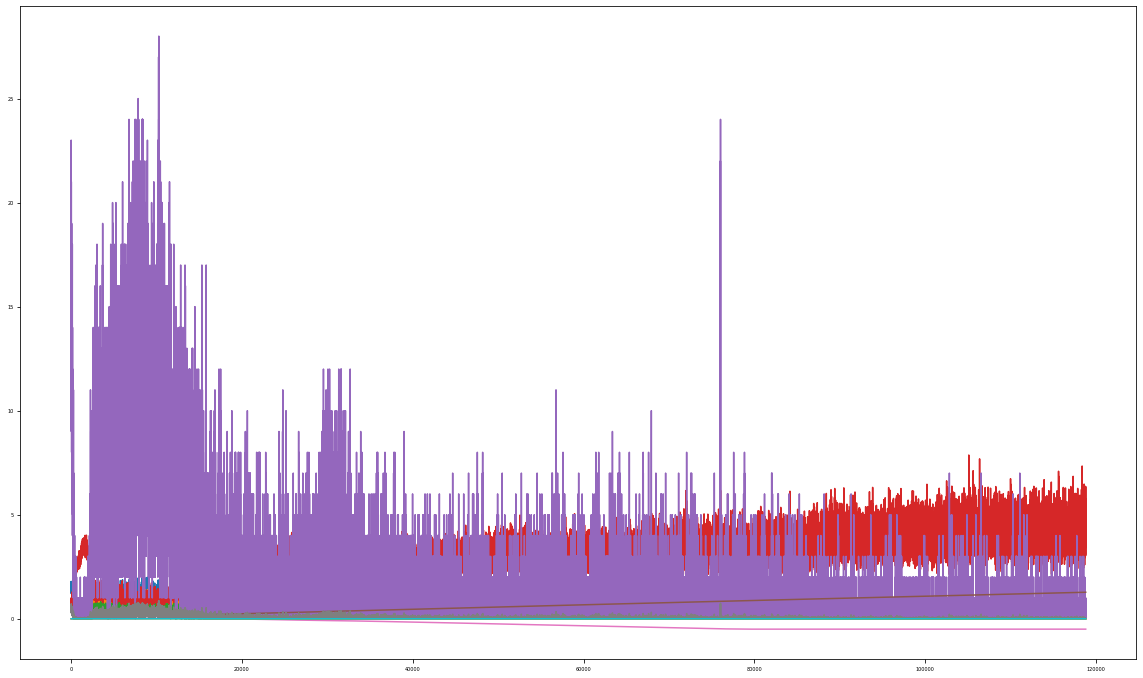

In [47]:
plt.figure(figsize = (20,12))
for k,v in exp_tmp[0].results_history.items():
    if v.__class__ == list:
        plt.plot(v)
plt.savefig("plt.jpg")
    

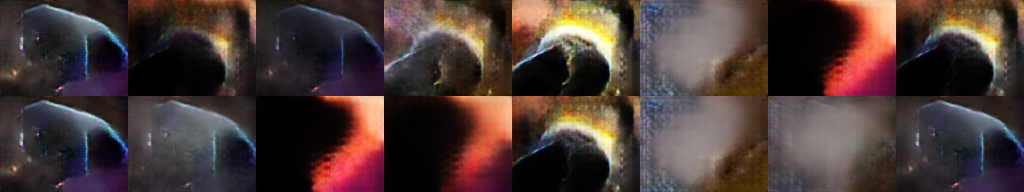

<Figure size 1280x304 with 0 Axes>

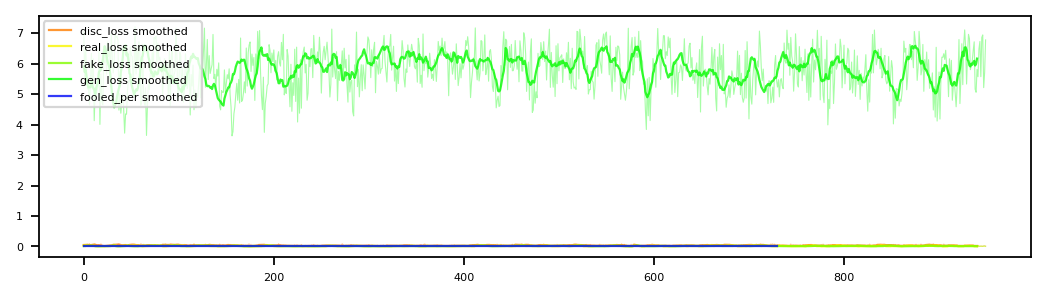

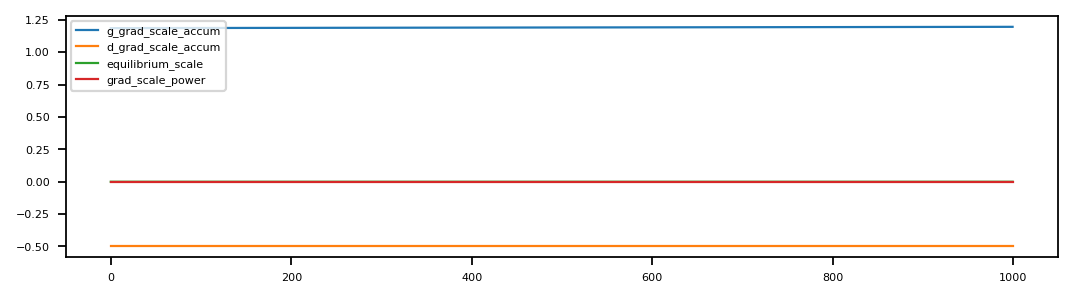

gen_loss: 5.909626007080078
disc_loss: 0.029762499034404755
fooled_per: 0.0009375
g_grad_scale_accum: 1.1964861154556274
d_grad_scale_accum: -0.5
Epoch: 5941 / 5941
Batches: 36
D Time: 1.3788928985595703 for images: True and graphs: True
Time for epoch:  18.482064247131348


In [ ]:
run_exp( exp_tmp[0])

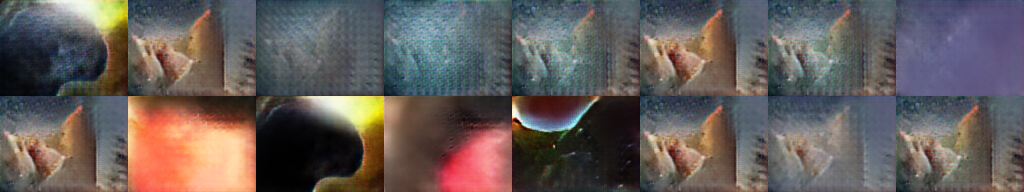

<Figure size 1280x304 with 0 Axes>

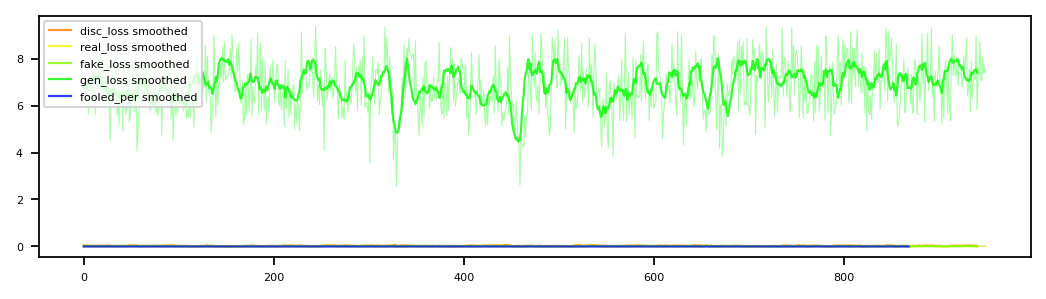

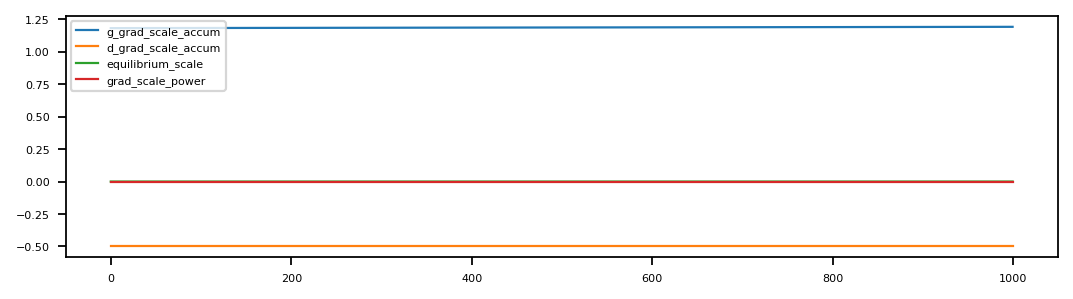

gen_loss: 7.321600914001465
disc_loss: 0.026802048087120056
fooled_per: 0.00125
g_grad_scale_accum: 1.1911157369613647
d_grad_scale_accum: -0.5
Epoch: 11881 / 11881
Batches: 36
D Time: 1.2796366214752197 for images: True and graphs: True
Time for epoch:  30.71211290359497


FileExistsError: [Errno 17] File exists: 'exp.data'

In [51]:
run_exp( exp_tmp[0])

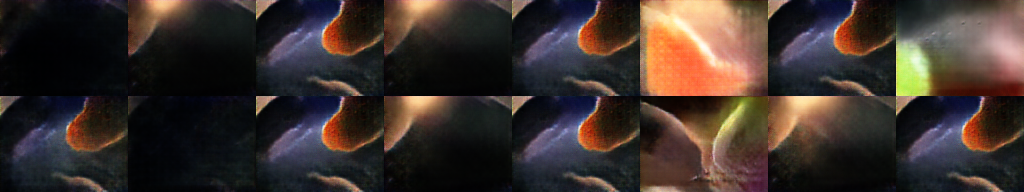

<Figure size 1280x304 with 0 Axes>

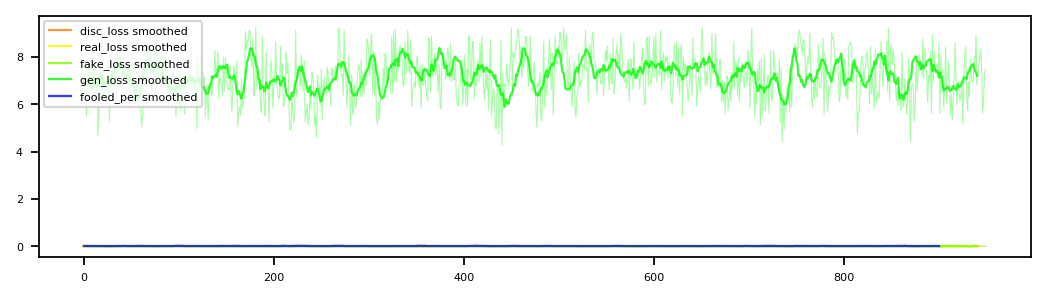

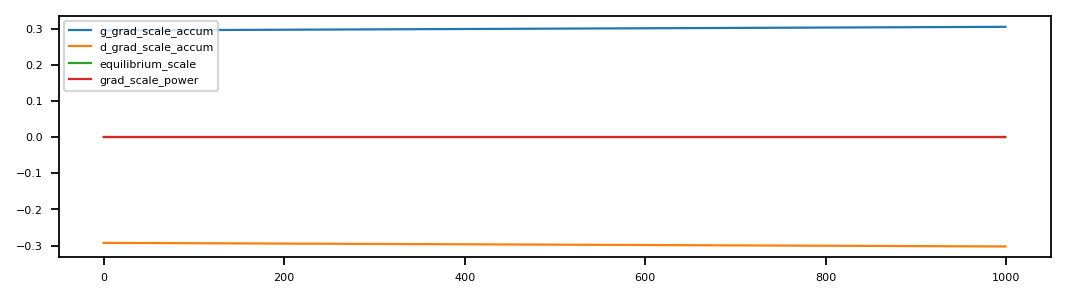

gen_loss: 7.156801700592041
disc_loss: 0.020891757681965828
fooled_per: 0.0003125
g_grad_scale_accum: 0.30440056324005127
d_grad_scale_accum: -0.30215010046958923
Epoch: 12641 / 12646
Batches: 36
D Time: 1.9427306652069092 for images: True and graphs: True
Time for epoch:  42.20837998390198
Starting epoch 12642


/opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Time for maintaining results: 0.049314260482788086
Time for epoch:  9.201939105987549
Starting epoch 12643
Time for maintaining results: 0.06080007553100586
Time for epoch:  9.087620496749878
Starting epoch 12644
Time for maintaining results: 0.07415199279785156
Time for epoch:  8.308803081512451
Starting epoch 12645
Time for maintaining results: 0.07252311706542969
Time for epoch:  8.745462894439697
Starting epoch 12646
Time for maintaining results: 0.06310582160949707
Time for epoch:  10.706525802612305
Batch size:  32
Starting from epoch:  12645
Starting epoch 12646
Time for maintaining results: 0.07516741752624512
Time for epoch:  9.381555318832397
Starting epoch 12647
Time for maintaining results: 0.06733179092407227
Time for epoch:  10.065109968185425
Starting epoch 12648
Time for maintaining results: 0.0687558650970459
Time for epoch:  9.458354711532593
Starting epoch 12649
Time for maintaining results: 0.06424164772033691
Time for epoch:  8.886260747909546
Starting epoch 12650


In [ ]:
run_exp( exp_tmp[0])

In [43]:
for i in range(1,30):
    print (f'{i} Million params is { ((i/3*1_000_000)**.5):.2f} latent space')

SyntaxError: invalid syntax (3081283339.py, line 2)

In [ ]:
import loadfunctions as lf
#fncs = (get_image_list,resize_and_load_image_list,easy_training_aug,cycle_hue_of_np_image_array)
#for i in fncs:
reload(loadfunctions)
import loadfunctions as lf
#from lf import save_np_image_list
lf.save_np_image_list(X_train,"augs for exp19")

In [ ]:
exp20 = copy.deepcopy(exp18)

In [ ]:
result = exp20.generator.predict(np.random.random( size=(1,64))) [0]
get_image(result).show()
#exp20.name = "created new random X_train"
#run_exp(exp20)

In [49]:
def save_models(gen,disc):
    gen.save("./generator.h5")
    disc.save("./discriminator.h5")
def summary_to_str(model):
    out=[]
    model.summary(print_fn=lambda x: out.append(x))
    out = '\n'.join(out)
    return out
    
def pre_save_exp(exp):
    import time    
    g_sum = summary_to_str(exp.generator)
    d_sum =  summary_to_str(exp.discriminator)
    os.popen(f'echo "{g_sum+d_sum}" > modal_summary.txt')
    print(g_sum)
    print(d_sum)    
    time.sleep(30)
    
            
             
def run_exp(exp:experiment):
    #global generator,discriminator
    #global discriminator_optimizer, generator_optimizer
    global train_step    
    global BATCH_SIZE
    if "exp" in os.getcwd():
        os.chdir("..")
    try:
        os.mkdir(f'exp-{exp.name}')
        os.chdir(f'exp-{exp.name}')
    except FileExistsError:
        os.chdir(f'exp-{exp.name}')
        if not exp.results_history:
            for f in os.listdir():
                try:
                    os.remove(f)
                except:
                    os.chdir(f)
                    for ff in os.listdir():
                        os.remove(ff)
                    os.chdir("..")
                    os.rmdir(f)
    
    try:
        train_step = train_step.python_function
    except:
        train_step = tf.function(train_step)
    lf.save_np_image_list(X_train,"augs")   
    #train_step = tf.function(train_step.python_function)
    if exp.results_history == None:
        #needed_records = (len(X_train)/exp.batch_size)*exp.epochs
        exp.results_history={'epoch':0}
        print("recreating models")
        
        exp.discriminator = discriminator_model(dropout=exp.dropout)
        exp.generator = generator_model(output_width=input_width,
                                        output_height=input_height,
                                        output_channels=input_channels,
                                        latent_dim =exp.latent_dim                                        
                                       )

        exp.generator.optimizer     = tf.keras.optimizers.Adam(exp.g_lr)
        exp.discriminator.optimizer = tf.keras.optimizers.Adam(exp.d_lr)
        
        start =1
        epochs = 10
        BATCH_SIZE = exp.batch_size
        d_grad_scale_accum = tf.Variable(exp.start_disc_gsa)
        g_grad_scale_accum = tf.Variable(exp.start_gen_gsa)
        grad_scale_power = tf.Variable(exp.grad_power)
    else:
        start=exp.results_history["epoch"]
        epochs=10
        BATCH_SIZE = exp.batch_size
        d_grad_scale_accum = tf.Variable(exp.start_disc_gsa)
        g_grad_scale_accum = tf.Variable(exp.start_gen_gsa)
        grad_scale_power = tf.Variable(exp.grad_power)
        
    
    ex_noise = tf.random.normal([16, exp.latent_dim])   
    if type(exp.batch_size) is list:
        if len(exp.batch_size) < exp.epochs:
            per = int(np.ceil( (exp.epochs/epochs)/len(exp.batch_size)))
            exp.batch_size = exp.batch_size*per
            print(exp.batch_size)
    
    use_batch_size=-1
    
    pre_save_exp(exp)
    
    exp_start_time = time.time()
    for ii,i in enumerate(range (start,start+exp.epochs,epochs)):
        old_batch_size=use_batch_size
        use_batch_size=exp.batch_size[ii]
        if old_batch_size != use_batch_size:
                old_batch_size=use_batch_size
                BATCH_SIZE= use_batch_size                
                slices = (X_train.astype("float16")/128)-1.0
                train_dataset = tf.data.Dataset.from_tensor_slices(slices).shuffle(len(X_train)).batch(use_batch_size)
                
        
        #regen noise even if batch_size is unchanged
        
        print("Batch size: ",use_batch_size)
        train(exp.generator,exp.discriminator,train_dataset,
                epochs=epochs,
                start_epoch=i,
                results_history=exp.results_history,
                d_grad_scale_accum = d_grad_scale_accum,
                g_grad_scale_accum = g_grad_scale_accum,
                grad_scale_power = grad_scale_power,
                example_noise= ex_noise,                
                use_grad_scale=exp.use_grad_scale
                )
       
    exp_run_time =time.time()-exp_start_time
    with open("exp.data","x") as f:
        f.write(f'run time: {str(exp_run_time/60)} minutes\n')
        for i in dir(exp):
            if ('__' not in i) and ('results_history' not in i):        
                f.write(f'{str(i)} : {eval("exp."+str(i))} \n')
   
    save_models(generator,discriminator)
    

In [ ]:
os.remove("exp.data")
with open("exp.data","x") as f:
    for i in dir(exp3):
        if ('__' not in i) and ('results_history' not in i):        
            f.write(f'{str(i)} : {eval("exp3."+str(i))} \n')


In [ ]:
print(os.getcwd())
print(os.chdir(".."))
#print(os.chdir("a"))

In [ ]:
generator_optimizer.learning_rate

In [ ]:
generator_optimizer.learning_rate= generator_optimizer.learning_rate*2.5

In [ ]:
discriminator_optimizer.learning_rate= discriminator_optimizer.learning_rate*5.0

In [ ]:
discriminator_optimizer.learning_rate

In [ ]:
try:
    test = tf.function(test.python_function)
except:
    pass

@tf.function
def test(a):    
    #a=tf.Variable([1,2])
    tf.tensor_scatter_nd_update(a,[0,1],[10])
    #print(a)
    return(a)
test(tf.Variable([1,2]))[0]

In [ ]:
# unfreeze the discriminator model
discriminator.trainable = True

In [ ]:
#load the most recent checkpoint into a new model
r = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
print(r)


In [ ]:
def save_models():
    generator.save("./generator.h5")
    discriminator.save("./discriminator.h5")
save_models()

In [ ]:
def load_models():
    generator = tf.keras.models.load_model("./generator.h5")
    discriminator = tf.keras.models.load_model("./discriminator.h5")
load_models()

In [ ]:
#with open('results_history.pkl', 'rb') as f:
#    results_history = pickle.load(f)

In [ ]:

train._results

In [ ]:

for thing in train._results:
    try:
        print(thing,f' length: {len(train._results[thing])}')
    except TypeError:
        print(thing,f' value: {train._results[thing]}')

In [ ]:
for thing in results_history:
    if type(results_history[thing]) != dict:
        try:
            print(thing,f' length: {len(results_history[thing])}, mean {np.mean(results_history[thing])}')
        except TypeError:
            try:
                print(thing,f' value: {results_history[thing].numpy()}')
            except AttributeError:
                print(thing,f' value: {results_history[thing]}')
    else:
        print(f'dict: {thing}')

In [ ]:
things = results_history['current_epoch']
for thing in things:
    try:
        print(thing,f' length: {len(things[thing])}')
    except TypeError:
        print(thing,f' value: {things[thing]}')

In [ ]:
results_history['fooled'][-1]

In [ ]:
results_history['fooled_per'][0]

In [ ]:

plt.figure(figsize=(8,2),dpi=160)
#plt.plot(results_history['fooled'])

plt.plot(results_history['fooled_per'][0:9000])
plt.plot(results_history['gen_lr'][0:9000])
plt.plot(results_history['disc_lr'][0:9000])

plt.yscale('log')
plt.show()

In [ ]:
results_history['current_epoch']["fooled_per"]